In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1335

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.1064
Average validation loss: 0.6611529588699341
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - loss: 0.1064 - val_loss: 0.6612
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - loss: 0.0776 - val_loss: 0.6612
Average validation loss: 0.6578354835510254
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - loss: 0.0776 - val_loss: 0.6595
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - loss: 0.0586 - val_loss: 0.6595
Average validation loss: 0.536884069442749
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 528ms/step - loss: 0.0586 - val_loss: 0.6186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step - loss: 2.9764e-05
Average validation loss: 0.13895105198025703
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 838ms/step - loss: 2.9764e-05 - val_loss: 0.1390
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - loss: 2.5385e-05 - val_loss: 0.1390
Average validation loss: 0.0753689669072628
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 825ms/step - loss: 2.5385e-05 - val_loss: 0.1072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step - loss: 2.3458e-05 - val_loss: 0.1072
Average validation loss: 0.027797795832157135
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 806ms/step - loss: 2.3458e-05 - val_loss: 0.0807
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_K

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 825ms/step - loss: 6.5975e-06
Average validation loss: 0.018485809676349163
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 834ms/step - loss: 6.5975e-06 - val_loss: 0.0185
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 775ms/step - loss: 5.4638e-06 - val_loss: 0.0185
Average validation loss: 0.038718901574611664
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 784ms/step - loss: 5.4638e-06 - val_loss: 0.0286
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 827ms/step - loss: 5.5887e-06 - val_loss: 0.0286
Average validation loss: 0.011650197052707275
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 836ms/step - loss: 5.5887e-06 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 812ms/step - loss: 5.45

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 847ms/step - loss: 6.0857e-06
Average validation loss: 0.009128011297434568
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 859ms/step - loss: 6.0857e-06 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 761ms/step - loss: 5.1719e-06 - val_loss: 0.0091
Average validation loss: 0.011939262854866683
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 769ms/step - loss: 5.1719e-06 - val_loss: 0.0105
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 775ms/step - loss: 4.4122e-06 - val_loss: 0.0105
Average validation loss: 0.006034047226421535
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 785ms/step - loss: 4.4122e-06 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 774ms/step - loss: 4.29

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 805ms/step - loss: 4.3669e-06
Average validation loss: 0.014623068459331989
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step - loss: 4.3669e-06 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 852ms/step - loss: 3.5084e-06 - val_loss: 0.0146
Average validation loss: 0.014705827878788113
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 861ms/step - loss: 3.5084e-06 - val_loss: 0.0147
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 784ms/step - loss: 3.0932e-06 - val_loss: 0.0147
Average validation loss: 0.005249285907484591
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 794ms/step - loss: 3.0932e-06 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 781ms/step - loss: 2.63

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - loss: 1.9176e-06
Average validation loss: 0.015959719739233453
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step - loss: 1.9176e-06 - val_loss: 0.0160
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 787ms/step - loss: 1.8449e-06 - val_loss: 0.0160
Average validation loss: 0.005827174560787777
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 797ms/step - loss: 1.8449e-06 - val_loss: 0.0109
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 778ms/step - loss: 1.6435e-06 - val_loss: 0.0109
Average validation loss: 0.00446944710953782
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 788ms/step - loss: 1.6435e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 764ms/step - loss: 5.2870e-06
Average validation loss: 0.02511312646092847
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 775ms/step - loss: 5.2870e-06 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 778ms/step - loss: 4.3298e-06 - val_loss: 0.0251
Average validation loss: 0.027108627930283548
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 787ms/step - loss: 4.3298e-06 - val_loss: 0.0261
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 764ms/step - loss: 3.5440e-06 - val_loss: 0.0261
Average validation loss: 0.018161718780174852
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 774ms/step - loss: 3.5440e-06 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 125s 776ms/step - loss: 3.06

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - loss: 3.9680e-06
Average validation loss: 0.007261054095579311
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 3.9680e-06 - val_loss: 0.0073
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - loss: 1.5333e-05 - val_loss: 0.0073
Average validation loss: 0.0318456479969124
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - loss: 1.5333e-05 - val_loss: 0.0196
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 786ms/step - loss: 1.3732e-05 - val_loss: 0.0196
Average validation loss: 0.019966760805497568
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 797ms/step - loss: 1.3732e-05 - val_loss: 0.0197
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 775ms/step - loss: 1.2396e-05 - val_loss: 0.0197
Average validation loss: 0.02615676944454511
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 787ms/step - loss: 1.2396e-05 - val_loss: 0.0213
Epoc

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 784ms/step - loss: 3.5087e-06
Average validation loss: 0.014053682181318956
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - loss: 3.5087e-06 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 886ms/step - loss: 2.6460e-06 - val_loss: 0.0141
Average validation loss: 0.007260626655936774
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 898ms/step - loss: 2.6460e-06 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 890ms/step - loss: 2.1991e-06 - val_loss: 0.0107
Average validation loss: 0.006271030695643276
56/56 ━━━━━━━━━━━━━━━━━━━━ 146s 902ms/step - loss: 2.1991e-06 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1D

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 1.5534e-06
Average validation loss: 0.00402819734881632
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - loss: 1.5534e-06 - val_loss: 0.0040
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 778ms/step - loss: 1.0338e-06 - val_loss: 0.0040
Average validation loss: 0.004082259350980166
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 789ms/step - loss: 1.0338e-06 - val_loss: 0.0041
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 787ms/step - loss: 8.0440e-07 - val_loss: 0.0041
Average validation loss: 0.003827950575214345
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 799ms/step - loss: 8.0440e-07 - val_loss: 0.0040
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 782ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 2.9933e-06
Average validation loss: 0.015023870704074701
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 2.9933e-06 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 777ms/step - loss: 1.9344e-06 - val_loss: 0.0150
Average validation loss: 0.049268724810745984
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 788ms/step - loss: 1.9344e-06 - val_loss: 0.0321
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 773ms/step - loss: 1.5302e-06 - val_loss: 0.0321
Average validation loss: 0.02198063305372165
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 784ms/step - loss: 1.5302e-06 - val_loss: 0.0288
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 774ms/step - loss: 1.3046e-06 - val_loss: 0.0288
Average validation loss: 0.020905445873116452
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 784ms/step - loss: 1.3046e-06 - val_loss: 0.0268


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 774ms/step - loss: 6.8189e-06
Average validation loss: 0.07677237670868635
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 785ms/step - loss: 6.8189e-06 - val_loss: 0.0768
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 4.1075e-06 - val_loss: 0.0768
Average validation loss: 0.04769206098280847
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 793ms/step - loss: 4.1075e-06 - val_loss: 0.0622
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 798ms/step - loss: 2.9405e-06 - val_loss: 0.0622
Average validation loss: 0.0067092648707330225
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 809ms/step - loss: 2.9405e-06 - val_loss: 0.0437
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 819ms/step - loss: 1.8542e-05
Average validation loss: 0.05667383565256993
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 830ms/step - loss: 1.8542e-05 - val_loss: 0.0567
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 766ms/step - loss: 1.3153e-05 - val_loss: 0.0567
Average validation loss: 0.015050910170733308
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 777ms/step - loss: 1.3153e-05 - val_loss: 0.0359
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 770ms/step - loss: 9.4356e-06 - val_loss: 0.0359
Average validation loss: 0.009573561086047752
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 781ms/step - loss: 9.4356e-06 - val_loss: 0.0271
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 782ms/step - loss: 1.2677e-05
Average validation loss: 0.012349618055547277
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 793ms/step - loss: 1.2677e-05 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 777ms/step - loss: 7.6163e-06 - val_loss: 0.0123
Average validation loss: 0.04845522832029943
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 788ms/step - loss: 7.6163e-06 - val_loss: 0.0304
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 779ms/step - loss: 5.6126e-06 - val_loss: 0.0304
Average validation loss: 0.02748070336820092
120/120 ━━━━━━━━━━━━━━━━━━━━ 284s 790ms/step - loss: 5.6126e-06 - val_loss: 0.0294
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 378s 779ms/step - loss: 4.4484e-06 - val_loss: 0.0294
Average validation loss: 0.013857483157577614
120/120 ━━━━━━━━━━━━━━━━━━━━ 379s 790ms/step - loss: 4.4484e-06 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 774ms/step - loss: 6.0477e-06
Average validation loss: 0.011772610370018002
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 784ms/step - loss: 6.0477e-06 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 775ms/step - loss: 4.4425e-06 - val_loss: 0.0118
Average validation loss: 0.026586049371821394
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 4.4425e-06 - val_loss: 0.0192
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 337s 773ms/step - loss: 3.4451e-06 - val_loss: 0.0192
Average validation loss: 0.01164563165123885
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 784ms/step - loss: 3.4451e-06 - val_loss: 0.0167
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 7

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 5.5069e-06
Average validation loss: 0.024027313159922414
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 791ms/step - loss: 5.5069e-06 - val_loss: 0.0240
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 765ms/step - loss: 3.6520e-06 - val_loss: 0.0240
Average validation loss: 0.07461051947902889
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 776ms/step - loss: 3.6520e-06 - val_loss: 0.0493
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 775ms/step - loss: 3.3417e-06 - val_loss: 0.0493
Average validation loss: 0.0617342598038789
160/160 ━━━━━━━━━━━━━━━━━━━━ 376s 785ms/step - loss: 3.3417e-06 - val_loss: 0.0535
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 502s 789ms/step - loss: 3.3679e-06 - val_loss: 0.0535
Average validation loss: 0.021954920614280126
160/160 ━━━━━━━━━━━━━━━━━━━━ 504s 800ms/step - loss: 3.3679e-06 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 760ms/step - loss: 1.9089e-05
Average validation loss: 0.024858320720959455
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - loss: 1.9089e-05 - val_loss: 0.0249
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 310s 780ms/step - loss: 2.2311e-05 - val_loss: 0.0249
Average validation loss: 0.05470831993967295
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 791ms/step - loss: 2.2311e-05 - val_loss: 0.0398
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 472s 797ms/step - loss: 2.4179e-05 - val_loss: 0.0398
Average validation loss: 0.10733372766524553
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 808ms/step - loss: 2.4179e-05 - val_loss: 0.0623
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 631s 785ms/step - loss: 2.2997e-05 - val_loss: 0.0623
Average validation loss: 0.05422255160499859
200/200 ━━━━━━━━━━━━━━━━━━━━ 633s 796ms/step - loss: 2.2997e-05 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 777ms/step - loss: 3.6459e-06
Average validation loss: 0.009879399898151557
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 788ms/step - loss: 3.6459e-06 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 771ms/step - loss: 2.9328e-06 - val_loss: 0.0099
Average validation loss: 0.008934124562559494
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 782ms/step - loss: 2.9328e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 562s 772ms/step - loss: 2.4175e-06 - val_loss: 0.0094
Average validation loss: 0.016123690874853006
240/240 ━━━━━━━━━━━━━━━━━━━━ 565s 783ms/step - loss: 2.4175e-06 - val_loss: 0.0116
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 750s 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1095563317462802, 0.04893439798150211, 0.015249485935394965, 0.007841815967403819, 0.007333493299782278, 0.005332595458991515, 0.03201401587133296, 0.015595332159039875, 0.012888809494324957, 0.012787360024085502, 0.031807912855680714, 0.034672062406898484, 0.015607380408182507, 0.026442981039091908, 0.03560025359616815, 0.041758427564102536, 0.030898917095444806, 0.011783131333114608]
std_val_losses =  [0.14567778264936165, 0.06559351685147635, 0.021626012041208988, 0.0033484461914600233, 0.00412965077688151, 0.0021113817593689612, 0.034831894444916134, 0.017105291122680104, 0.0338245364396006, 0.01537186148829375, 0.03167582062161888, 0.04148372499849289, 0.01601995522998633, 0.0423838043299315, 0.06832831868265231, 0.0380130454490341, 0.030434203267544317, 0.008379585522273435]


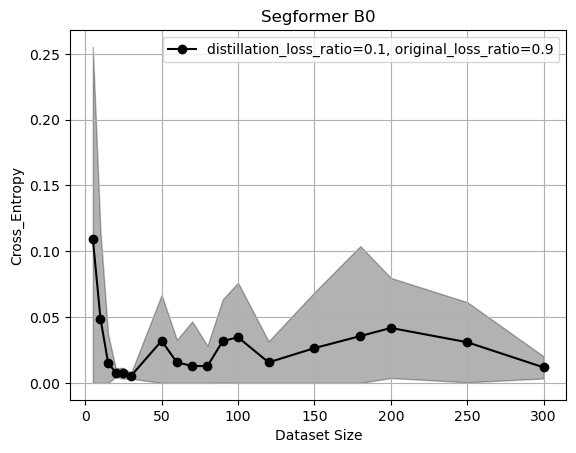

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()